https://pypi.python.org/pypi/windrose/

https://github.com/python-windrose/windrose

http://nbviewer.jupyter.org/github/python-windrose/windrose/blob/master/windrose_sample_random.ipynb

In [1]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval/')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
mpl.style.use('ggplot')
import createFolder as cF
import datetime

import get_Haukeli_obs_data as obsDat
import calc_date as cd
import netCDF4
import fill_values as fv
import save_fig as sF
import read_MRR as pMRR
from scipy.integrate import simps
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm


from windrose_edit import WindroseAxes

In [2]:
# solve for a and b
def best_fit(X, Y):

    xbar = np.nansum(X)/len(X)
    ybar = np.nansum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = np.nansum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = np.nansum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

#    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

In [3]:
station = 'Haukeliseter' #
year= '2016'
month = '12'

hh = '00'

#t = ['17', '18','19', '20', '21', '22', '23', '24', '25', '26', '27']
t = ['20', '21', '22', '23', '24', '25', '26', '27']
#t = ['20']

In [4]:
### Haukeli obs
txtdir = '../../Data/eklima/'
txt_filename = 'Observations-hour_minutes.txt'

In [5]:
tid = '00'

### Figures 
savefig = 0
figdir = '../../Figures/Windrose_Scatter'
cF.createFolder('%s/' %(figdir))
form = 'png'
################################################################
### MEPS
level = '10m'
ncdir_10m = '../../Data/MEPS/%s/%s_%s' %(station,level,hh)
level = 'sfc'
nc_dir_sfc = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
level = 'ml'
nc_dir_ml = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
# air temperature
var_name_air_temp = 'air_temperature_ml'
air_temp_dir = '%s/%s' %(nc_dir_ml,var_name_air_temp)
# snow fall amount
var_name_snow = 'snowfall_amount_ml'
snow_dir = '%s/%s' %(nc_dir_ml,var_name_snow)
# graupel fall amount
var_name_graupel = 'graupelfall_amount_ml'
graupel_dir = '%s/%s' %(nc_dir_ml,var_name_graupel)
# atmosphere_cloud_ice_content_ml
var_name_cl_ice = 'atmosphere_cloud_ice_content_ml'
cl_ice_dir = '%s/%s' %(nc_dir_ml,var_name_cl_ice)

################################################################
### MRR
MRR_dir = '../../Data/MRR/processed_MRR'

################################################################
### Retrieval 
nc_dir_retrieval = '../../Data/Retrieved_SWC'

################################################################

In [6]:
## MRR ######
fnMRR      = dict()
time_MRR   = dict()
height_MRR = dict()
Ze         = dict()

In [7]:
## RETRIEVAL ######
fnRet      = dict()
retrieved_snowfall_amount = dict()
SWC        = dict()
SWP_ret    = dict() 
SWC_con    = dict()
time_con   = dict()
SWP_mean_ret= dict()

In [8]:
air_temp_file     = dict()
snow_file         = dict()
graupel_file      = dict()
cl_ice_file       = dict()

fn_air_temp       = dict()
fn_snow           = dict()
fn_graupel        = dict()
fn_cl_ice         = dict()

time_ml           = dict()
air_temp_ml       = dict()
pressure_ml       = dict()
snow_amount_ml    = dict()
graupel_amount_ml = dict()
cl_ice_ml         = dict()

thickness_ml      = dict()
ice_amount_ml     = dict()
time              = dict()
height_ml         = dict()
height            = dict()
density_ml        = dict()
SWP_model         = dict()

In [9]:
fn_10m = dict()

time_10m   = dict()
x_wind_10m = dict()
y_wind_10m = dict()

wd_MEPS    = dict()
ws_MEPS    = dict()

In [10]:
Rd = 287.    # gas constant for dry air [J kg^-1 K^-1]

In [11]:
# read in the Haukeliseter observation file, sorted by daily values
Haukeli = pd.read_csv('%s/%s' %(txtdir, txt_filename),\
                    sep = ';',header=19, skipfooter = 11, engine= 'python')

DateHour = Haukeli['Date-Hour(UTC)']

DD   = Haukeli['DD'].astype(float)             # Wind direction (FF); [degrees]
FF   = Haukeli['FF'].astype(float)             # Wind speed (10 meters above ground);m/s

In [12]:
idxFF = np.where(FF[:] == -9999)
idxDD = np.where(DD[:] == -9999)

FF[idxFF[0][:]] = np.nan
DD[idxDD[0][:]] = np.nan


In [13]:
ws_WM, wd_WM, dt_wind, hour_wind, day_wind, month_wind, year_wind = obsDat.valid_values_wind(FF, DD, DateHour)

In [14]:
champ = 255.
date_blue = np.array([1,74,159])/255.
no1 = np.array([79,94,26])/champ
no2 = np.array([131,156,45])/champ
no3 = np.array([71,153,112])/champ
no4 = np.array([77,111,157])/champ
no5 = np.array([157,58,55])/champ
no6 = np.array([211,120,50])/champ
no7 = np.array([218,181,70])/champ


#no1 = np.array([8,128,193])/champ
#no2 = np.array([88,174,217])/champ
#no3 = np.array([251,64,0])/champ
#no4 = np.array([255,134,19])/champ
#no5 = np.array([0,172,87])/champ
#no6 = np.array([70,205,120])/champ
#no7 = np.array([125,98,179])/champ
#no8 = np.array([163,150,202])/champ
#no9 = np.array([99,99,99])/champ



memb_col = np.array([99,99,99])/champ       # ensemble member color
#dofe = np.array([64,180,233])/champ         # color for double fence measurement
dofe = np.array([125,98,179])/champ

In [15]:
for day in t:
## MRR ######  
    fnMRR[day] = netCDF4.Dataset('%s/VMRR_%s%s%s.nc' %(MRR_dir,year,month,day) ,'r')
    time_MRR[day]   = fnMRR[day].variables['time'][:]
    height_MRR[day] = fnMRR[day].variables['height'][:]

    Ze[day] = pMRR.read_and_mask(fnMRR[day],'Ze', np.nan)         # vertical Ze profile for retrieval

## RETRIEVAL ######
    fnRet[day] = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, day))

    retrieved_snowfall_amount[day] = fnRet[day].variables['retrieved_snowfall_amount'][:]
    SWC[day] = fnRet[day].variables['SWC'][:]
    
    swpret = []
    swpret = simps(SWC[day][:,:], height_MRR[day], axis = 0)
    SWP_ret[day] = swpret


### hourly SWC 
mean_SWC = dict()
for day in t:
    if day == '20':
        time_con[day]= np.concatenate((time_MRR[day], time_MRR[str(int(day)+1)][:30]))
        SWC_con[day] = np.concatenate((SWC[day], SWC[str(int(day)+1)][:,:30]),axis=1)
    elif day == '27':
        time_con[day]= np.concatenate((time_MRR[str(int(day)-1)][23*60+30:], time_MRR[day]))
        SWC_con[day] = np.concatenate((SWC[str(int(day)-1)][:,23*60+30:], SWC[day]),axis=1)
    else:
        time_con[day]= np.concatenate((time_MRR[str(int(day)-1)][23*60+30:], time_MRR[day], time_MRR[str(int(day)+1)][:30]))
        SWC_con[day] = np.concatenate((SWC[str(int(day)-1)][:,23*60+30:], SWC[day], SWC[str(int(day)+1)][:,:30]),axis=1)
    
    avg60 = []
    if day == '20':
        for i in range(30,SWC_con[day].shape[1],60):
            avg60.append(np.nanmean(SWC_con[day][:,i:(i+60)],axis=1))
        mean_SWC[day] = np.transpose(avg60)
    else:
        for i in range(0,SWC_con[day].shape[1],60):
            avg60.append(np.nanmean(SWC_con[day][:,i:(i+60)],axis=1))
        mean_SWC[day] = np.transpose(avg60)

### hourly SWP
    swpret = []
    swpret = simps(mean_SWC[day][:,:], height_MRR[day], axis = 0)
    SWP_mean_ret[day] = swpret

# for plotting, only values larger than 0.01
    a,b = np.where(retrieved_snowfall_amount[day][:,:] < 0.01)
    SWC[day][a[:],b[:]]                       = np.nan
    retrieved_snowfall_amount[day][a[:],b[:]] = np.nan
    np.transpose(Ze[day])[a[:],b[:]]          = np.nan
#    mean_SWC[day][a[:],b[:]]                  = np.nan
    a1,b1 = np.where(mean_SWC[day][:,:] < 0.01)    
    mean_SWC[day][a1[:],b1[:]] = np.nan
    
    fnMRR[day].close()
    fnRet[day].close()

/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval/read_MRR.py:95: RuntimeWarning: invalid value encountered in less
  mask = np.ma.getmaskarray(var[:,:])
/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval/read_MRR.py:96: RuntimeWarning: invalid value encountered in less
  var = np.ma.array(var[:,:], mask = mask, fill_value = fill_value)


In [16]:
# layer for average snow water content within 200 m
nlay= 15
bot = []
top = []
for k in range(0, nlay):
    bot.append(100.+ k*200)
    top.append(bot[k]+200)

avg_SWC_ml = dict()
h_avg      = dict()
t_avg      = dict()

In [17]:
# best fit variables
ys = []
st = []
yfit = [] 

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater_equal
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in less
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in less
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:207: RuntimeWarning: Mean of empty slice
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:219: RuntimeWarning: Mean of empty slice


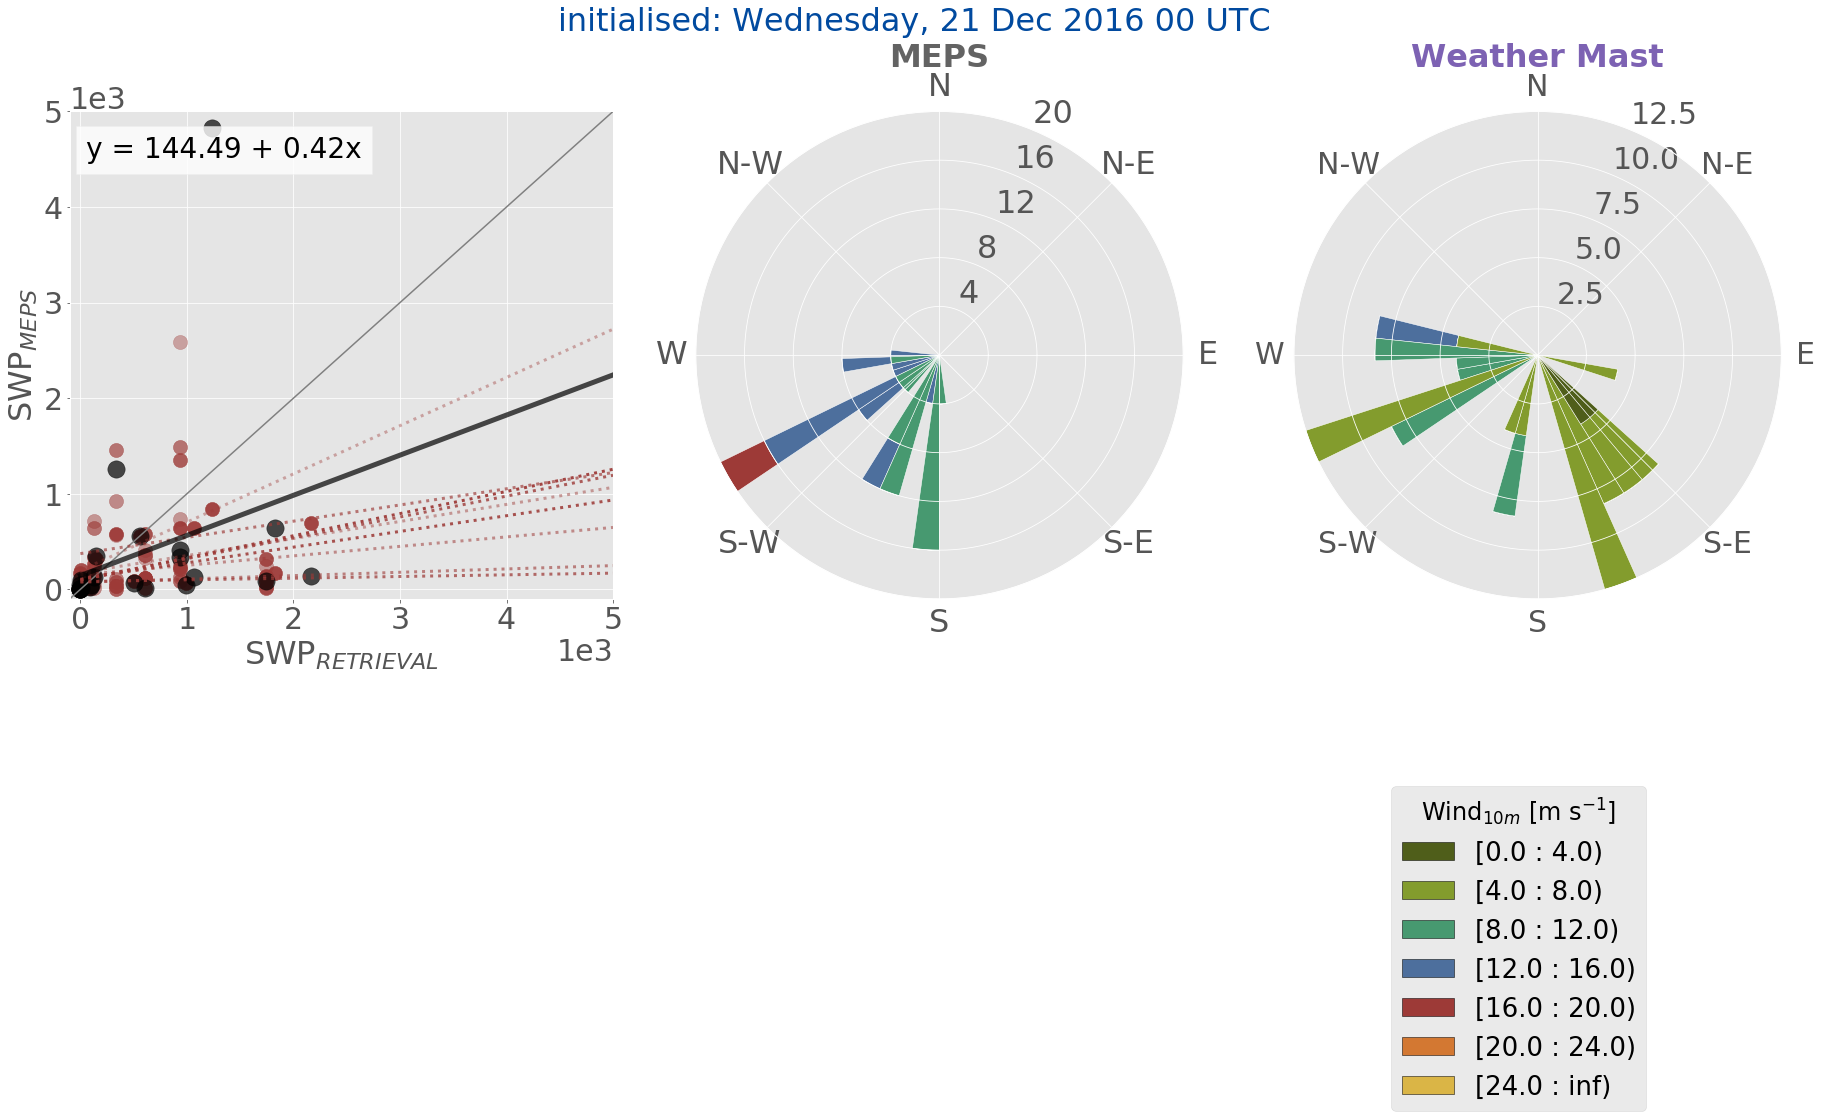

In [18]:
#for k in range(1,np.asarray(t).shape[0]):
for k in range(1,2):
    day = t[k]
## MEPS ######
    for ens_memb in range(0,10):
         
        air_temp_file[ens_memb]= '%s/%s%s%s_%s_%s.nc' %(air_temp_dir,year,month,day,tid,ens_memb)
        snow_file[ens_memb]    = '%s/%s%s%s_%s_%s.nc' %(snow_dir,year,month,day,tid,ens_memb)
        graupel_file[ens_memb] = '%s/%s%s%s_%s_%s.nc' %(graupel_dir,year,month,day,tid,ens_memb)
        cl_ice_file[ens_memb]  = '%s/%s%s%s_%s_%s.nc' %(cl_ice_dir,year,month,day,tid,ens_memb)
        
        
        fn_air_temp[ens_memb]  = netCDF4.Dataset(air_temp_file[ens_memb])
        fn_snow[ens_memb]      = netCDF4.Dataset(snow_file[ens_memb])
        fn_graupel[ens_memb]   = netCDF4.Dataset(graupel_file[ens_memb]) 
        fn_cl_ice[ens_memb]    = netCDF4.Dataset(cl_ice_file[ens_memb])
        # read in the netcdf 10m file
        fn_10m[ens_memb] = netCDF4.Dataset('%s/%s%s%s_%s_%s.nc' %(ncdir_10m,year,month,day,hh,ens_memb))
        
# Read in time to know initialisation time (plotting)    
        time_ml[ens_memb] = fn_snow[ens_memb].variables['time']
        time_ml[ens_memb] = fv.fill_nan(time_ml[ens_memb][:])
        

        ini_day = datetime.datetime.utcfromtimestamp(time_ml[0][0]).day   # day of initialisation
        hr = datetime.datetime.utcfromtimestamp(time_ml[0][0]).hour       # first hour of initialisation?
        calday, calmon = cd.get_dayname(year, month, ini_day)
        
# Read in the pressure, and the air temperature to calculate ice amount from [kg/kg] to [kg/m^3]
        air_temp_ml[ens_memb] = fn_air_temp[ens_memb].variables[var_name_air_temp]
        pressure_ml[ens_memb] = fn_snow[ens_memb].variables['pressure_ml']
# Read in the variable name which should be plotted  
        snow_amount_ml[ens_memb]    = fn_snow[ens_memb].variables[var_name_snow]
        graupel_amount_ml[ens_memb] = fn_graupel[ens_memb].variables[var_name_graupel]
        cl_ice_ml[ens_memb]         = fn_cl_ice[ens_memb].variables[var_name_cl_ice]

# Read in the wind
        x_wind_10m[ens_memb] = fn_10m[ens_memb].variables['x_wind_10m'][:]
        y_wind_10m[ens_memb] = fn_10m[ens_memb].variables['y_wind_10m'][:]
        
        x_wind_10m[ens_memb] = fv.fill_nan(x_wind_10m[ens_memb])
        y_wind_10m[ens_memb] = fv.fill_nan(y_wind_10m[ens_memb])

# Create wind speed and direction variables
        wd_MEPS[ens_memb] = np.arctan2(y_wind_10m[ens_memb][:,0], x_wind_10m[ens_memb][:,0])
        ws_MEPS[ens_memb] = np.sqrt((x_wind_10m[ens_memb][:,0])**2 + (y_wind_10m[ens_memb][:,0])**2) 

        wd_MEPS[ens_memb] = 270-np.rad2deg(wd_MEPS[ens_memb])  # convert from math to meteo direction and to degrees

        ws_MEPS[ens_memb] = ws_MEPS[ens_memb][~np.isnan(wd_MEPS[ens_memb])]
        wd_MEPS[ens_memb] = wd_MEPS[ens_memb][~np.isnan(wd_MEPS[ens_memb])]
        

# create an array with time of the shape of the variable
        lead_time   = np.arange(0,snow_amount_ml[ens_memb].shape[0])
        model_level = np.arange(0,snow_amount_ml[ens_memb].shape[1])
        td,Y        = np.meshgrid(lead_time,model_level)

# substitute missing values with nan 
        pressure_ml[ens_memb]       = fv.fill_nan(pressure_ml[ens_memb][:])
        air_temp_ml[ens_memb]       = fv.fill_nan(air_temp_ml[ens_memb][:])
        snow_amount_ml[ens_memb]    = fv.fill_nan(snow_amount_ml[ens_memb][:])
        graupel_amount_ml[ens_memb] = fv.fill_nan(graupel_amount_ml[ens_memb][:])
        cl_ice_ml[ens_memb]         = fv.fill_nan(cl_ice_ml[ens_memb][:])
# get ice amount (snow+graupel)
        ice_amount_ml[ens_memb]     = snow_amount_ml[ens_memb] + graupel_amount_ml[ens_memb] + cl_ice_ml[ens_memb]
    
# layer thickness to calculate height
        thickness_ml[ens_memb]      = fn_snow[ens_memb].variables['layer_thickness']
        thickness_ml[ens_memb]      = fv.fill_nan(thickness_ml[ens_memb][:])
    
        thickness = thickness_ml[ens_memb]
        h_above = []
        h_above.append(np.zeros(thickness[:,:].shape[0]))
        th_arr = np.nansum([np.asarray(h_above)[:,0], thickness[:,0]], axis = 0)
        h_above.append(th_arr)
        for i in range(2,thickness[:,:].shape[1]):
            th_arr = np.nansum([h_above[i-1], thickness[:,i-1]], axis = 0)
            h_above.append(th_arr)
        height_ml[ens_memb] = np.transpose(h_above)
        
        
# get only valuable values not nan    
        time_ml[ens_memb]       = (time_ml[ens_memb][~np.isnan(time_ml[ens_memb])])
        time[ens_memb]          = (td[:,~np.isnan(ice_amount_ml[ens_memb]).any(axis=1)])
        height[ens_memb]        = (height_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:])
        thickness_ml[ens_memb]  = (thickness_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:]) 
        air_temp_ml[ens_memb]   = (air_temp_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:])
        pressure_ml[ens_memb]   = (pressure_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1),:])
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb][~np.isnan(ice_amount_ml[ens_memb]).any(axis=1)])

# calculate density at each level
        density_ml[ens_memb] = pressure_ml[ens_memb]/(Rd*air_temp_ml[ens_memb])
        

# convert from [kg/kg] to [kg/m^3]
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb]*density_ml[ens_memb])

# convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb]*1000.)

# calculate mean of snowfall amount in each layer, every 200m
        SWC_ml = []
        h_mid = []
        for k in range(0, nlay):
            tidx,hidx = np.where(np.logical_and(height_ml[ens_memb][:,:] >= bot[k], height_ml[ens_memb][:,:] < top[k]))
    
    # average in layer
            SWC_ml.append(np.nanmean(ice_amount_ml[ens_memb][:,hidx[:]], axis = 1))
            h_mid.append((bot[k]+top[k])/2)
        avg_SWC_ml[ens_memb] = SWC_ml

        hidx = []
        tidx = []
        for i in range(0,np.asarray(avg_SWC_ml[ens_memb]).shape[1]):
            hidx.append(h_mid)
        h_avg[ens_memb] = hidx
        for i in range(0,np.asarray(avg_SWC_ml[ens_memb]).shape[0]):
            tidx.append(time[ens_memb][0,:])
        t_avg[ens_memb] = tidx



    

        SWP_ml = []

        for i in range(0,np.transpose(avg_SWC_ml[ens_memb]).shape[0]):
            SWP_ml.append(simps(y = np.transpose(avg_SWC_ml[ens_memb])[i,:], 
                            x = np.asarray(h_avg[ens_memb])[i,:]))
        SWP_model[ens_memb] = SWP_ml

        h1, h2 = np.where(height[ens_memb][:,:] > 3000)
        ice_amount_ml[ens_memb][h1[:],h2[:]] = np.nan
        time[ens_memb][h2[:],h1[:]]          = -9999
        height[ens_memb][h1[:],h2[:]]        = np.nan
    
#    print('%s, %s %s %s' %(calday, day, calmon, year))
 #   r1, r2 = np.where(mean_SWC[day] == np.nanmax(mean_SWC[day] ))
  #  if len(r1) == 0 or len(r2) == 0:
   #     print('max SWC in retrieval: NaN')
    #else:
     #   print('max SWC in retrieval: %.2f kg m^-3 in %.1f m; @ %.02d UTC' %(np.nanmax(mean_SWC[day]),height_MRR[day][r1],r2))


#    ml1, ml2 = np.where(np.transpose(avg_SWC_ml[0]) == np.nanmax(np.transpose(avg_SWC_ml[0])[:24,:] ))
 #   if len(ml1) == 0 or len(ml2) == 0:
  #      print('max SWC in ml       : NaN')
   # else:
    #    print('max SWC in ml       : %.2f kg m^-3 in %.1f m; @ %.02d UTC' %(np.nanmax(np.transpose(avg_SWC_ml[0])[:24,:]), np.asarray(h_avg[0])[ml1,ml2], datetime.datetime.utcfromtimestamp(time_ml[0][ml1]).hour))
    
    

###################################################################################

    

    for ens_memb in range(0,10):
        if len(ice_amount_ml[ens_memb]) == 0:
            continue
        else:
            a2,b2 = np.where(ice_amount_ml[ens_memb][:,:] < 0.01)    ## 0.001? retrieved_snowfall_amount = iwcpsd*0.85*e-3*3600*24
            ice_amount_ml[ens_memb][a2[:],b2[:]] = np.nan
        if len(avg_SWC_ml[ens_memb]) == 0:
            continue
        else:
            a3,b3 = np.where(np.asarray(avg_SWC_ml[ens_memb]) < 0.01)
            avg_SWC_ml[ens_memb] = np.asarray(avg_SWC_ml[ens_memb])
            avg_SWC_ml[ens_memb][a3[:],b3[:]] = np.nan
########################################
#### calculate line fit of fraction between 
# sample points 
#    for i in range(0,nlay-1):
 #       X = mean_SWC[day][i,:]        # retrieval
  #      Y = avg_SWC_ml[0][i+1,:25]    # MEPS
# solution
#        a, b = best_fit(X, Y)
 #       ys.append(a)
  #      st.append(b)
#best fit line:
#y = 0.80 + 0.92x
   #     yy = [a + b * xi for xi in X]
    #    yfit.append(yy)
    
#    yfi = [np.mean(ys) + np.mean(st) * xi for xi in np.nanmean(mean_SWC[day][:,:],axis=0)]
 #   print('best fit line:\ny = {:.2f} + {:.2f}x'.format(np.mean(ys), np.mean(st)))
  #  X = np.arange(0,2,0.2)
   # Y = np.mean(ys) + np.mean(st) * np.arange(0,2,0.2)

########################################
#### calculate line fit of fraction between 
# sample points 
    X = SWP_mean_ret[day]  # retrieval
    Y = dict()
    a = dict()
    b = dict()
    yy = dict()
    yfi = dict()
    xx = dict()
    yy = dict()
    for ens_memb in range(0,2):
        X = SWP_mean_ret[day]  # retrieval
        Y[ens_memb] = SWP_model[ens_memb][:25]              # MEPS
# solution
        a[ens_memb], b[ens_memb] = best_fit(X, Y[ens_memb])
        yy[ens_memb] = [a[ens_memb] + b[ens_memb] * xi for xi in X]
        yfi[ens_memb] = [np.mean(a[ens_memb]) + np.mean(b[ens_memb]) * xi for xi in np.nanmean(mean_SWC[day][:,:],axis=0)]
#        print('best fit line:\ny = {:.2f} + {:.2f}x'.format(np.mean(a[ens_memb]), np.mean(b[ens_memb])))
        
        
        xx[ens_memb] = np.arange(0,5.5*1000,0.5*1000)
        yy[ens_memb] = np.mean(a[ens_memb]) + np.mean(b[ens_memb]) * np.arange(0,5.5*1000,0.5*1000)
    for ens_memb in range(2,10):
        X = SWP_mean_ret[day][0:25:3]  # retrieval
        Y[ens_memb] = SWP_model[ens_memb][:9]              # MEPS
# solution
        a[ens_memb], b[ens_memb] = best_fit(X, Y[ens_memb])
        yy[ens_memb] = [a[ens_memb] + b[ens_memb] * xi for xi in X]
        yfi[ens_memb] = [np.mean(a[ens_memb]) + np.mean(b[ens_memb]) * xi for xi in np.nanmean(mean_SWC[day][0:25:3],axis=0)]
#        print('best fit line:\ny = {:.2f} + {:.2f}x'.format(np.mean(a[ens_memb]), np.mean(b[ens_memb])))
        
        
        xx[ens_memb] = np.arange(0,5.5*1000,0.5*1000)
        yy[ens_memb] = np.mean(a[ens_memb]) + np.mean(b[ens_memb]) * np.arange(0,5.5*1000,0.5*1000)
        
    
    
    
    fig_name = '%s%s%s.%s' %(year,month,day,form)
    
    fontsize = 32.
    tick_fs = fontsize-2
    label_fs = fontsize
    legend_fs = fontsize-4
    
    levels = np.arange(0,28,4)
    cmap = mpl.colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7])
    norm = mpl.colors.BoundaryNorm(boundaries = levels, ncolors=cmap.N)
    plt.hist([0,1])
    plt.close()
##############
  #  em = np.arange(1,2)
#    colors = cm.tab10(np.linspace(0,1/10, len(em)))
 #   em2 = np.arange(2,10)
 #   colors2 = cm.tab10(np.linspace(2/10,1, len(em2)))
    
    fig = plt.figure(figsize=(27.,17.6))

    gs = GridSpec(2,6)
## 1st subplot --- scatter plot
    ax0 = plt.subplot(gs[0:1,0:2])
    ax0.plot([-100, 5000.], [-100, 5000.], linestyle='-',color='gray')
# plot points and fit line
#    for ens_memb,c in zip(em, colors):
    
    for ens_memb in range(1,2):
        if len(SWP_model[ens_memb][:25]) == 0:
            continue
        else:
            ax0.scatter(SWP_mean_ret[day], SWP_model[ens_memb][:25], color=no5, alpha = 1.-1/15, s = 200 )
            ax0.plot(xx[ens_memb], yy[ens_memb],linestyle=':',color=no5, linewidth=3.,alpha = 1.-1/15)
#    for ens_memb,c in zip(em2, colors2):
    for ens_memb in range(2,10):
        if len(SWP_model[ens_memb][:25]) == 0:
            continue
        else:
            ax0.scatter(SWP_mean_ret[day][0:25:3], SWP_model[ens_memb][:9], color=no5, alpha = 1.-ens_memb/15, s = 200 )
            ax0.plot(xx[ens_memb], yy[ens_memb],linestyle=':',color=no5, linewidth=3.,alpha = 1.-ens_memb/15)
    
    ax0.scatter(SWP_mean_ret[day], SWP_model[0][:25], color='k', alpha = 0.7, s = 300 )
    ax0.plot(xx[0], yy[0],linestyle='-',color='k', linewidth=5.,alpha = 0.7)
    ax0.text(0.03,0.95, 'y = {:.2f} + {:.2f}x'.format(np.mean(a[0]), np.mean(b[0])),
            verticalalignment ='top', horizontalalignment='left', color = 'k',
             transform = ax0.transAxes, fontsize = legend_fs,
             bbox={'facecolor':'white','alpha':.8,'pad':10})
    
    
    ax0.plot()
    ax0.set_xlim([-100,5000.])
    ax0.set_ylim([-100,5000.])
    
    
    ax0.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    
    ax0.set_xticks(np.arange(0,5.5*1000,1*1000))
    ax0.xaxis.offsetText.set_fontsize(tick_fs)
    ax0.set_xlabel('SWP$_{RETRIEVAL}$',fontsize=label_fs)
    
    ax0.set_yticks(np.arange(0,5.5*1000,1*1000))
    ax0.set_ylabel('SWP$_{MEPS}$', fontsize=label_fs)
    ax0.yaxis.offsetText.set_fontsize(tick_fs)
    ax0.tick_params(axis='both', labelsize=tick_fs)
    
    ## 2nd subplot --- wind MEPS
    ax1 = plt.subplot(gs[0:1,2:4], projection='windrose')
    ax1.bar(wd_MEPS[0][:25], ws_MEPS[0][:25], normed=True, opening=1.0, edgecolor='white',nsector=45, 
                 cmap=cmap,bins=np.arange(0, 28, 4))
    ax1._info['bins']
    ax1.set_title('MEPS', fontsize=fontsize,y=1.08, color=memb_col, fontweight='bold')
    ax1.tick_params(labelsize = label_fs)
    
    
    
## 3rd subplot --- wind weather mast
    ax2 = plt.subplot(gs[0:1,4:6], projection='windrose')
    bar = ax2.bar(wd_WM[int(day)-1][:], ws_WM[int(day)-1][:], normed=True, opening=1.0, edgecolor='white',nsector=45, 
                 cmap=cmap,bins=np.arange(0, 28, 4))
    ax2._info['bins']
    ax2.set_title('Weather Mast', fontsize=fontsize,y=1.08, color=dofe, fontweight='bold')
    ax2.tick_params(labelsize = tick_fs)
    fig.suptitle('initialised: %s, %s %s %s %s UTC' %(calday,ini_day,calmon,year,hh), color = date_blue,fontsize = fontsize)
    
    
##  --- wind rose legend
    ax2.set_legend()
    ax2.legend(title ='Wind$_{10m}$ [m s$^{-1}$]',fontsize=legend_fs-2)
    ax2.get_legend().get_title().set_fontsize('24')
    
    ################
    plt.tight_layout(pad=6.5, w_pad=2.5, h_pad=2.5)
    #plt.tight_layout()
    

    if savefig ==1:
        sF.save_figure_landscape(figdir, fig_name, form)
        print('saved: %s/%s' %(figdir, fig_name))
    else:
        plt.show()
    plt.close()
    
    
    for ens_memb in range(0,10):
        fn_10m[ens_memb].close()
        fn_snow[ens_memb].close()
        fn_air_temp[ens_memb].close()  
        fn_cl_ice[ens_memb].close()